In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import xarray as xr

In [2]:
ds = xr.open_dataset(os.path.join(os.getenv("HOME"), "test_run_phosphorus_wdir", "iterate_02.nc"))
ds

<xarray.Dataset>
Dimensions:       (depth: 30, depth_edges: 31, nbnds: 2)
Coordinates:
  * depth         (depth) float64 5.0 15.01 25.07 35.32 ... 775.1 825.0 875.0
  * depth_edges   (depth_edges) float64 0.0 10.0 20.02 ... 800.0 850.0 900.0
Dimensions without coordinates: nbnds
Data variables:
    depth_bounds  (depth, nbnds) float64 ...
    depth_delta   (depth) float64 ...
    po4           (depth) float64 ...
    dop           (depth) float64 ...
    pop           (depth) float64 ...
    po4_s         (depth) float64 ...
    dop_s         (depth) float64 ...
    pop_s         (depth) float64 ...
Attributes:
    history:  2021-03-31 12:28:20: created by nk_ooc.test_problem.model_state...

In [3]:
def penalty(fit_coeffs):
    weight = ds["depth_delta"].values[:]
    weight = weight / weight.sum()
    var_approx = np.interp(
        ds["depth"].values[:], 100.0 * np.cumsum(fit_coeffs[:2]), fit_coeffs[2:]
    )
    truth = ds[varname].values[:]
    anom_relative = (var_approx - ds[varname].values[:]) / truth.max()
    return np.sqrt((weight * anom_relative * anom_relative).sum())

def penalty_fixed_nodes(fit_coeffs):
    weight = ds["depth_delta"].values[:]
    weight = weight / weight.sum()
    var_approx = np.interp(
        ds["depth"].values[:], 100.0 * np.cumsum(fixed_nodes[:]), fit_coeffs[:]
    )
    truth = ds[varname].values[:]
    anom_relative = (var_approx - ds[varname].values[:]) / truth.max()
    return np.sqrt((weight * anom_relative * anom_relative).sum())

In [4]:
init_vals = {}
init_vals["po4"] = {"shallow": 0.1, "deep": 4.0}
init_vals["dop"] = {"shallow": 0.07, "deep": 0.01}
init_vals["pop"] = {"shallow": 0.02, "deep": 0.002}

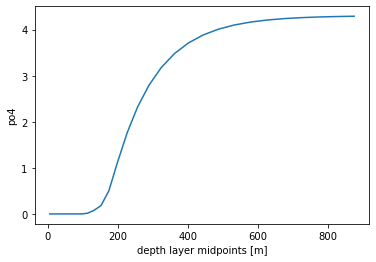

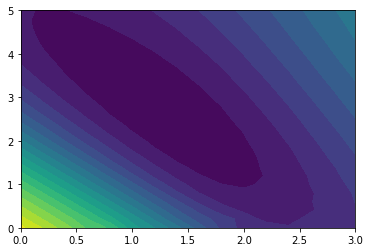

[1.4 2.4 0.1 4. ]
 active_mask: array([0, 0, 0, 0])
        cost: 0.0007675030119769544
         fun: array([0.03917915])
        grad: array([ 3.49925460e-09, -9.43571252e-09,  1.72896775e-06, -5.14676778e-09])
         jac: array([[ 8.93141976e-08, -2.40835031e-07,  4.41297889e-05,
        -1.31364958e-07]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 2731
        njev: 2311
  optimality: 9.445864280434413e-09
      status: 1
     success: True
           x: array([1.27215333, 2.58512699, 0.0054633 , 4.14031561])
****************************************


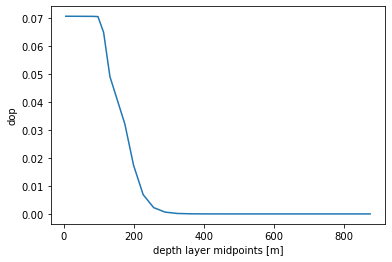

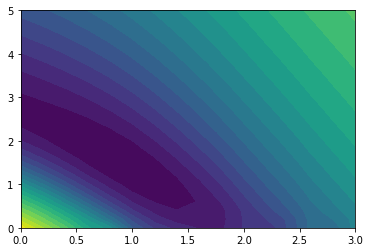

[1.   1.4  0.07 0.01]
 active_mask: array([0, 0, 0, 0])
        cost: 8.789837886116674e-05
         fun: array([0.01325884])
        grad: array([ 2.43232824e-07, -3.52475866e-07,  1.21330550e-06,  2.09999196e-06])
         jac: array([[ 1.83449592e-05, -2.65842220e-05,  9.15091950e-05,
         1.58384326e-04]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 3989
        njev: 3108
  optimality: 3.5247586560997016e-07
      status: 3
     success: True
           x: array([9.46346792e-01, 1.41996254e+00, 7.05060115e-02, 1.51110271e-04])
****************************************


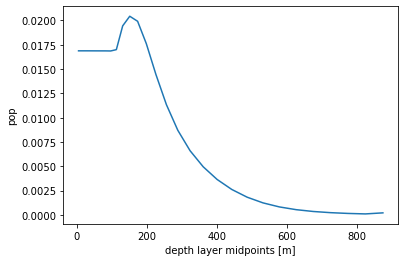

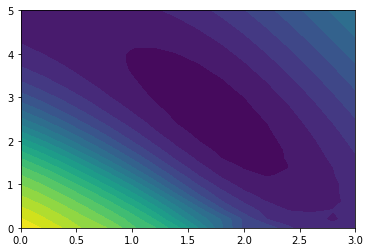

[1.8e+00 2.4e+00 2.0e-02 2.0e-03]
 active_mask: array([0, 0, 0, 0])
        cost: 0.001250698950893723
         fun: array([0.05001398])
        grad: array([ 5.25120362e-05, -1.62373926e-04,  4.22539461e-05,  2.75542943e-04])
         jac: array([[ 0.00104995, -0.00324657,  0.00084484,  0.00550932]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 8745
        njev: 6542
  optimality: 0.00016237392637406556
      status: 3
     success: True
           x: array([1.73830384e+00, 2.48007055e+00, 1.78825786e-02, 7.93022778e-04])
****************************************


In [5]:
for varname in ["po4", "dop", "pop"]:
    ds[varname].plot()
    plt.show()

    h1_vals = np.linspace(0.0, 3.0, 16)
    h2_vals = np.linspace(0.0, 5.0, 26)

    fit_coeffs_0 = np.array([init_vals[varname]["shallow"], init_vals[varname]["deep"]])

    bounds = ( np.array([0.0, 0.0]), np.array([np.inf, np.inf]) )

    res = np.zeros((len(h2_vals), len(h1_vals)))

    for i1, x1 in enumerate(h1_vals):
        for i2, x2 in enumerate(h2_vals):
            fixed_nodes = np.array([x1, x2])
            res[i2, i1] = optimize.least_squares(
                penalty_fixed_nodes,
                fit_coeffs_0,
                bounds=bounds,
                max_nfev=10000,
                ftol=1.0e-10,
            ).cost

    plt.contourf(h1_vals, h2_vals, res, 20)
    plt.show()

    ind = np.unravel_index(np.argmin(res, axis=None), res.shape)

    fit_coeffs_0 = np.array(
        [h1_vals[ind[1]],
         h2_vals[ind[0]],
         init_vals[varname]["shallow"],
         init_vals[varname]["deep"]]
    )
    print(fit_coeffs_0)

    bounds = ( np.array([0.0, 0.0, 0.0, 0.0]), np.array([np.inf, np.inf, np.inf, np.inf]) )
    res = optimize.least_squares(
        penalty, fit_coeffs_0, bounds=bounds, max_nfev=10000, ftol=1.0e-10
    )
    print(res)
    print(40 * "*")